In [1]:
from google.colab import drive
import os

# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# fastdtw 패키지 설치
!pip install fastdtw
!pip install tslearn
!pip install imbalanced-learn  # SMOTE를 사용하기 위해 imbalanced-learn 설치
!pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542083 sha256=8cc0c4d10a961a69a069d90e9a93d3631c936da03ee0c6479a2f45988458a3a1
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
from dtaidistance import dtw
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Flatten
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tslearn.metrics import dtw_path
from fastdtw import fastdtw
from imblearn.metrics import specificity_score

In [4]:
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample100.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample100.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample100.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample100.csv')

In [5]:
# 데이터 전처리
X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)  # 1차원 배열(벡터)로 변환
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)  # 1차원 배열(벡터)로 변환

# 소수 클래스와 다수 클래스 식별
target_counts = pd.Series(y_train).value_counts()
minority_class = target_counts.idxmin()
majority_class = target_counts.idxmax()

# 소수 클래스 샘플 추출
X_minority = X_train[y_train == minority_class]
X_major = X_train[y_train == majority_class]

In [6]:
from collections import defaultdict
from dtaidistance import dtw

# DTW 기반 데이터 증강 함수
def generate_dtw_synthetic_data(X, num_samples):
    synthetic_data = []

    for _ in range(num_samples):
        # 두 개의 랜덤 시계열 선택
        idx1, idx2 = np.random.choice(len(X), 2, replace=False)
        a, b = X[idx1], X[idx2]

        # DTW Warping Path 계산
        path = dtw.warping_path(a, b)

        # a 시계열 기준 매칭된 b 값 평균 계산
        a_to_b_map = defaultdict(list)
        for i, j in path:
            a_to_b_map[i].append(b[j])

        a_mapped_values = []
        for i in range(len(a)):
            if i in a_to_b_map:
                avg_list = [(a[i] + b_j) / 2 for b_j in a_to_b_map[i]]
                final_avg = np.mean(avg_list)  # 평균들의 평균
            else:
                final_avg = a[i]
            a_mapped_values.append(final_avg)

        # b 시계열 기준 매칭된 a 값 평균 계산
        b_to_a_map = defaultdict(list)
        for i, j in path:
            b_to_a_map[j].append(a[i])

        b_mapped_values = []
        for j in range(len(b)):
            if j in b_to_a_map:
                avg_list = [(b[j] + a_i) / 2 for a_i in b_to_a_map[j]]
                final_avg = np.mean(avg_list)  # 평균들의 평균
            else:
                final_avg = b[j]
            b_mapped_values.append(final_avg)

        # 최종 증강 데이터: a 기반 평균과 b 기반 평균을 다시 평균화
        dtw_augmented = np.mean([a_mapped_values, b_mapped_values], axis=0)
        synthetic_data.append(dtw_augmented)

    return np.array(synthetic_data)

# 증강할 샘플 개수 설정
nCnt = len(X_train) - len(X_minority)

# DTW 기반 증강 데이터 생성
X_aug = generate_dtw_synthetic_data(X_minority, num_samples=nCnt)
y_aug = np.full(len(X_aug), minority_class)


# 원본 데이터와 합성 데이터 결합
X_synthetic = np.concatenate((X_train, X_aug), axis=0)
y_synthetic = np.concatenate((y_train, y_aug), axis=0)

In [7]:
# DTW 거리 계산 함수
def compute_dtw_distance(series1, series2):
    distance, _ = fastdtw(series1, series2)
    return distance

# X_train과 X_test 사이의 DTW 거리 계산하여 대칭 행렬로 표현
dtw_matrix = np.zeros((len(X_synthetic), len(X_test)))

# DTW 거리 계산
for i, train_series in enumerate(X_synthetic):
    for j, test_series in enumerate(X_test):
        distance = compute_dtw_distance(train_series, test_series)
        dtw_matrix[i, j] = distance

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [9]:
# 10. Stratified K-Fold 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Stratified K-Fold 사용

In [10]:
# 11. 교차 검증 및 모델 학습
best_threshold = None
best_specificity = 0
best_model = None

for fold, (train_index, val_index) in enumerate(skf.split(X_synthetic, y_synthetic)): #X_train_resampled, y_train_resampled로 학습
    print(f"Fold {fold+1}")

    # 데이터 분할
    X_train_fold, X_val_fold = X_synthetic[train_index], X_synthetic[val_index] #X_train_resampled, y_train_resampled로 학습
    y_train_fold, y_val_fold = y_synthetic[train_index], y_synthetic[val_index] #X_train_resampled, y_train_resampled로 학습

    rf_model = RandomForestClassifier(random_state=42)
    # 모델 학습
    rf_model.fit(X_train_fold, y_train_fold)

    # 검증 데이터 예측 (확률값 예측)
    y_pred_proba = rf_model.predict_proba(X_val_fold)[:, 1]

    # 최적 임계값 찾기 (Specificity 최대화)
    thresholds = np.linspace(0, 1, 100)  # 임계값 후보 생성
    for threshold in thresholds:
        y_pred_temp = (y_pred_proba >= threshold).astype(int)
        specificity = specificity_score(y_val_fold, y_pred_temp)
        if specificity > best_specificity:
            best_specificity = specificity
            best_threshold = threshold
            best_model = rf_model # 현재 fold의 모델 저장

print(f"Best Threshold: {best_threshold}")

# 12. 테스트 데이터 예측 (최적 모델 및 임계값 사용)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Best Threshold: 0.9595959595959597


In [11]:
# 예측 함수 정의

# 예측 함수 정의 (최적 모델 및 임계값 사용)
def predict_with_best_rf(X_test):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    return (y_pred_proba >= best_threshold).astype(int)

def predict_with_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_cart(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_knn(X_train, y_train, X_test, k=3):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_xgboost(X_train, y_train, X_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_lstm(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

def predict_with_cnn(X_train, y_train, X_test):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

In [12]:
# Define predictions dictionary
predictions = {
    "Logistic Regression": predict_with_logistic_regression(X_synthetic, y_synthetic, X_test),
    "CART": predict_with_cart(X_synthetic, y_synthetic, X_test),
    "KNN": predict_with_knn(X_synthetic, y_synthetic, X_test),
    "XGBoost": predict_with_xgboost(X_synthetic, y_synthetic, X_test),
    "LSTM": predict_with_lstm(X_synthetic, y_synthetic, X_test),
    "CNN": predict_with_cnn(X_synthetic, y_synthetic, X_test),
    "Best Random Forest": predict_with_best_rf(X_test)  # 최적 RF 모델 예측
}

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:11:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(*

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Logistic Regression 성능 평가:
정확도: 0.6387
F1-Score: 0.7412
Recall: 0.8441
specificity: 0.3133
혼동 행렬 (Confusion Matrix):
[[104 228]
 [ 82 444]]


CART 성능 평가:
정확도: 0.6830
F1-Score: 0.7733
Recall: 0.8821
specificity: 0.3675
혼동 행렬 (Confusion Matrix):
[[122 210]
 [ 62 464]]


KNN 성능 평가:
정확도: 0.7308
F1-Score: 0.8044
Recall: 0.9030
specificity: 0.4578
혼동 행렬 (Confusion Matrix):
[[152 180]
 [ 51 475]]


XGBoost 성능 평가:
정확도: 0.7168
F1-Score: 0.8058
Recall: 0.9582
specificity: 0.3343
혼동 행렬 (Confusion Matrix):
[[111 221]
 [ 22 504]]


LSTM 성능 평가:
정확도: 0.6329
F1-Score: 0.6660
Recall: 0.5970
specificity: 0.6898
혼동 행렬 (Confusion Matrix):
[[229 103]
 [212 314]]


CNN 성능 평가:
정확도: 0.6667
F1-Score: 0.7737
Recall: 0.9297
specificity: 0.2500
혼동 행렬 (Confusion Matrix):
[[ 83 249]
 [ 37 489]]


Best Random Forest 성능 평가:
정확도: 0.4907
F1-Score: 0.3030
Recall: 0.1806
specificity: 0.9819
혼동 행렬 (Confusion Matrix):
[[326   6]
 [431  95]]




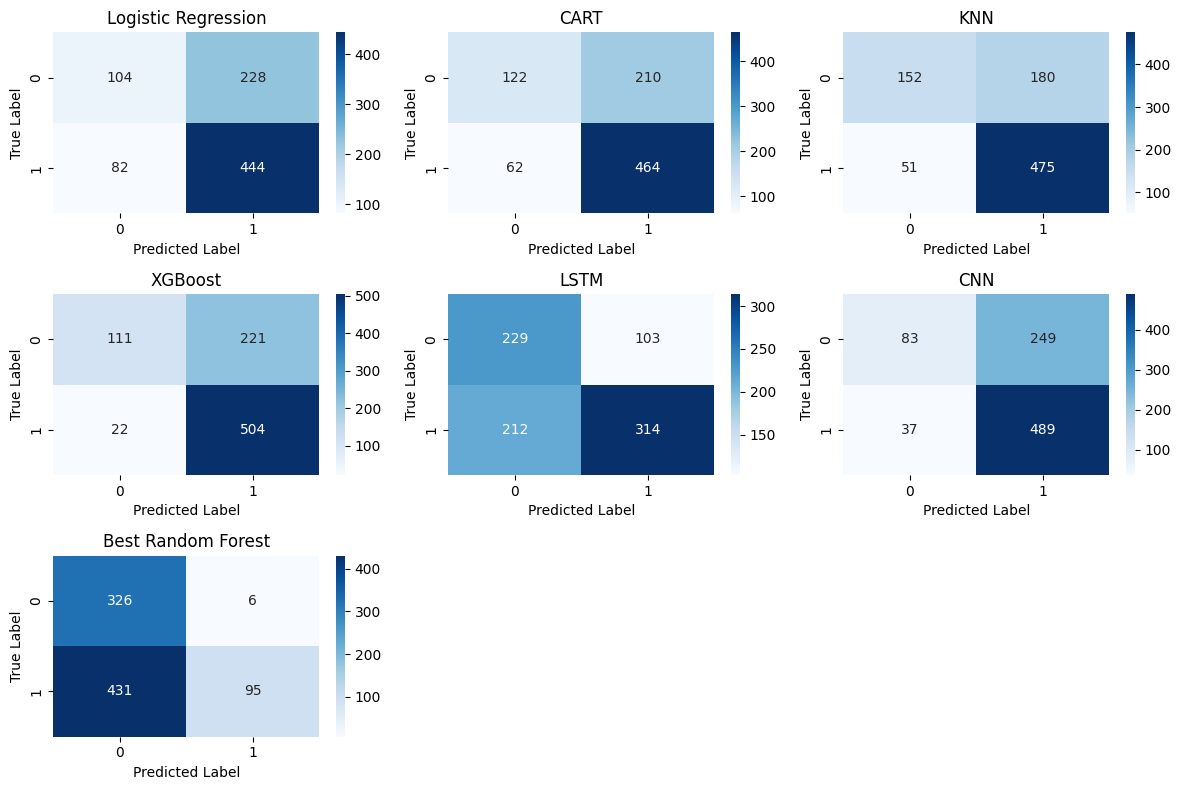

In [14]:
# 성능 평가
for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    specificity = specificity_score(y_test, pred_y)
    conf_matrix = confusion_matrix(y_test, pred_y)

    print(f"{model_name} 성능 평가:")
    print(f"정확도: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"specificity: {specificity:.4f}")
    print("혼동 행렬 (Confusion Matrix):")
    print(conf_matrix)
    print("\n")

# Confusion Matrix 시각화
plt.figure(figsize=(12, 8))  # Adjust figure size to accommodate more subplots
num_models = len(predictions)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_models + num_cols - 1) // num_cols  # Calculate number of rows needed

for i, (model_name, pred_y) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, pred_y)
    plt.subplot(num_rows, num_cols, i + 1)  # Use calculated rows and columns
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(model_name)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()